# Predicting Soccer Matches With Pandas

## By: Doug Abramowicz

Learning new things is hard. This is not an orginal thought but, well, none of the ideas in this blog post are particularly original. I'm not writing this to show the world some brilliant insight that I developed, much as I wish such a thing existed. Instead this post's only purpose is to make it a little easier for people like me last year (knowing very little about anything) to become people like me now (still knowing very little about most things, but a little bit more about data preparation in Python using Pandas). Unfortunately, if you're coming here with *absolutely zero* experience with coding or databases then this might be a struggle, because explaining every little detail and foundational concept takes up a lot of space, and this article's already far too long as it is (probably because of run-on sentences like this one). However, if you've ever coded anything at all then I think you'll be fine, because I explain just about everything specific to this project in detail.

Before I continue, I’m going to stress an important point that you may have glossed over. This is about *preparing data for analysis*, not actual data science, which people seem to find more interesting. There will be no talk of correlations or statistical significance or feature selection or any of those other fun concepts. While I do have a simplistic yet functional logistic regression model who’s results are detailed at the end, I won’t talk about what they mean. In the (increasingly likely) event that I remain on the bench for an extended period of time, I hope to develop an exciting model and write a blog delving into its rationale and results. This is not that. This is basically an introduction to leveraging Pandas, a Python library made for exactly this type of analysis, and sadly not a kind of bear. Now let's get this show on the road.

The first step in data prep is to understand what the data will be used for. This project's goal is to predict the winner of soccer matches based on the FIFA ratings of each team’s players. Thus, we need to know the FIFA ratings of the players in a given match and said match’s result. For the unfamiliar, FIFA is a global crime syndicate that moonlights as the governing body of international soccer. Every year a video game is released called FIFA (*insert year*) that periodically rates every meaningful player in the world from a scale of 1-99. Coincidentally, there is a Kaggle dataset that contains exactly the information we need (and a whole bunch more that we don’t). This can be found here: https://www.kaggle.com/hugomathien/soccer. I have assumed that the average FIFA rating for the players on a team is an acceptable proxy for a team’s quality; whether or not this assumption is valid is the type of question I’ll answer in the next post, should there be a next post, eventually.

### Compiling the Data

First thing's first, let's import the packages we'll need to run this code. Most of these are for the data science at the end; the only ones we need to worry about for the bulk of this article are the first two: Pandas and SQLite.

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Then we can get started by placing the tables from Kaggle into a Pandas *dataframe*. You can think of a dataframe as an excel spreadsheet (a *series* is a dataframe with only one column -- this may or may not come up later) (Hint: it will). The intricacies of this code aren't really important, because it can mostly be copy-and-pasted to connect to any SQLite database. 

In [2]:
conn = sqlite3.connect(r"C:\Users\dabramowicz\Downloads\database.sqlite")

player_attributes = pd.read_sql_query('select * from Player_Attributes;', conn)
match = pd.read_sql_query('select * from Match;', conn)

And here is what they look like:

In [3]:
player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [4]:
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


As you can see, there's a whole lot going on. The player_attributes table is organized so that each row represents one player, and all of the columns list information about him. The match table is structured so that each row represents one match, and then the columns provide information about that match. This may all seem very basic, but trust me that it will come into play later. 

### Pandas Fundamentals

So now we have our data, and can start thinking about actually working with it. We will do so using the tools provided by Pandas, so I think it's a good idea to make sure everyone has at least a foundational grasp about what coding with Pandas looks like.

Generally, a dataframe is stored in a lower-case space-less variable, for example the player_attributes dataframe that we just created from a table in the SQLite database. You often want to pick out specific columns from a dataframe on which to perform operations or access data, and this is done by "slicing" the dataframe using brackets. For example, we can slice the dataframe to only contain the "overall_rating" column by putting that column's name in brackets after the dataframe of interest. Then we can apply the .head() function to show the ratings of the first 5 players.

In [5]:
player_attributes['overall_rating'].head()

0    67.0
1    67.0
2    62.0
3    61.0
4    61.0
Name: overall_rating, dtype: float64

Whereas you slice the columns of a dataframe by simply selecting the columns, you slice a dataframe's rows by foisting conditions upon them. (I know, "foisting" may not entirely fit, but I've never passed up an opportunity to use funny-sounding words, and I never will.) Here we will only select the matches where the player is rated above an 85, and show the first 5 rows meeting that condition:

In [6]:
player_attributes[(player_attributes['overall_rating'] > 85)].head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
3247,3248,106019,30690,2008-02-22 00:00:00,86.0,90.0,left,medium,low,53.0,...,78.0,86.0,20.0,20.0,20.0,9.0,20.0,49.0,20.0,20.0
3248,3249,106019,30690,2007-08-30 00:00:00,86.0,90.0,left,medium,low,53.0,...,78.0,86.0,20.0,20.0,20.0,9.0,20.0,49.0,20.0,20.0
3249,3250,106019,30690,2007-02-22 00:00:00,89.0,91.0,left,medium,low,53.0,...,78.0,86.0,12.0,18.0,20.0,9.0,8.0,49.0,9.0,8.0
6215,6216,1075,30727,2009-08-30 00:00:00,86.0,90.0,right,medium,low,83.0,...,90.0,91.0,26.0,36.0,32.0,11.0,21.0,80.0,21.0,21.0
6216,6217,1075,30727,2009-02-22 00:00:00,87.0,90.0,right,medium,low,83.0,...,90.0,90.0,21.0,26.0,32.0,11.0,21.0,80.0,21.0,21.0


In the above code, the condition is inside the parenthesis for clarity. Because that condition is ultimately inside brackets slicing the player_attributes dataframe, each row of the dataframe will be compared to the condition, and it will only show those rows for which it is true. Notice that when you slice by row you still retain all the dataframe's columns, and when you slice by column you retain all of its rows. The easiest way to combine the two operations is using .loc:

In [7]:
player_attributes.loc[player_attributes['overall_rating'] > 85, 'overall_rating'].head()

3247    86.0
3248    86.0
3249    89.0
6215    86.0
6216    87.0
Name: overall_rating, dtype: float64

When using .loc, everything before the comma refers to slicing rows and everything following the comma slices columns.

Lastly, you will often see me use the function .reset_index() at the end of most lines of code. Whenever you perform operations on a dataframe, it's often a good idea to reset the index for a variety of reasons, which I'll try to outline as they come up. Got it? Good. Because it's time for one last preface.

### For Loops: The Bad Way

I think the best way to explain how to properly prepare this data is not to just give you the correct answer (insofar as there is such a thing as a “correct” answer), but to give you a little bit of context as to how I got there. In that spirit, I’m going to show you how I first thought to solve this problem. I won’t spend too much time on it, because it is bad, but I will spend a little, because it is important. While my sincere advice is to not bother with interpreting all the code in this section, you do you, man.

First, I selected only games in the premier league. Then I cut it to only the columns that seemed relevant, like so:

In [ ]:
premier_league_id = 1729
premier_league_games = match[match['league_id'] == premier_league_id].reset_index()
premier_league_games = premier_league_games[['league_id', 'season', 'date', 'home_team_api_id', 
                                             'away_team_api_id', 'home_team_goal', 'away_team_goal', 
                                             'home_player_1', 'home_player_2', 'home_player_3', 
                                             'home_player_4', 'home_player_5', 'home_player_6', 
                                             'home_player_7', 'home_player_8', 'home_player_9', 
                                             'home_player_10', 'home_player_11', 'away_player_1',
                                             'away_player_2', 'away_player_3', 'away_player_4', 
                                             'away_player_5', 'away_player_6', 'away_player_7', 
                                             'away_player_8', 'away_player_9', 'away_player_10', 
                                             'away_player_11']].reset_index()

Then, I ventured to the dark side. I created my very own Frankenstein’s monster (which I suppose could be called Abramowicz’s monster, but I’d rather not be associated with this mess). This is that creature:

In [ ]:
for match in range(len(premier_league_games)):
    for column in range(1,12):
        for team in ['home', 'away']:
            player_id = premier_league_games.loc[match, '{}'.format(team) + '_player_' + '{}'.format(column)]
            ratings = player_attributes.loc[player_attributes['player_api_id'] == player_id].reset_index()
            if ratings.empty:
                premier_league_games.loc[match, '{}'.format(team) + '_player_' + '{}'.format(column) + '_rating']= np.nan
            else:
                rating = ratings.iloc[0,5]
                premier_league_games.loc[match, '{}'.format(team) + '_player_' + '{}'.format(column) + '_rating'] = rating

Much as we may be terrified of it, let's break this bad boy down. This code has three nested For Loops. In total, it basically says for every player in every match, I want to do *x*. That *x* is to, in one table, find the column with his player_id. Then, in a separate table, use that player_id to find the rows with information about him. Assuming that you find any rows, take the first rating that you see and plug it back in to that original table in a freshly-made column.

I was proud of this. It was complicated and messy and I still understood it, and thus I have proven once again that I am, in fact, smart. Then I showed it to a Senior Manager at CapTech, the one who inspired me to begin this whole project in the first place. She looks over it, thoughtfully, and then casually asks how long it took to run. Not knowing the answer, I respond with the classic “That's a great question. Let me consult with my team and we can circle back.” I later timed it: 520 seconds, or almost 9 minutes, also known as “a really long time to sit there pretending to be working while your computer is occupied.”

### Normalizing Databases: The Good Way

So, what’s the better way to do this? If you have ever written a SQL query or taken a course on databases (and managed to keep yourself awake), then you already know the answer. The best way is to take each logical entity (match or player, for example) and give it its own table. The tables interact through sharing some columns, or keys. I can then join the tables on these keys and perform operations on these combined tables. This is cleaner and this is faster. *Much* faster. Like, 25 times faster. (An analogous model took 20 seconds, and to be honest I’m surprised the gap isn’t even larger).

If you're curious about *why* it goes so much faster and have five minutes to spare, then read this: https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6. If you only have enough time to finish this paragraph, then do that, because it summarizes the article. The answer lies in something called *vectorization*. Whereas the system of For Loops above forces the program to compute a function for *each individual row*, a vectorized solution allows Pandas to compute a function for *each individual dataframe*. Behind the scenes Pandas is equipped to work on arrays as one single unit, but the system of For Loops forces Pandas to treat each row of data as the foundational unit. The rest of the code will strive to faciliate vectorized solutions.

So, like I said before, we have two key entities: matches and players. Let us now consider how they interact. Each match contains a bunch of players. And each player plays in a bunch of matches. This is what we in the biz call a many-to-many relationship. And if I know one thing about relational databases it’s that a many-many relationship calls for a junction table! A junction table is the link between the players and matches tables. This is how I ultimately want my data to look:

In [32]:
players_final.head()

,player_api_id,date,overall_rating
0,505942,2016-02-18 00:00:00,67.0
1,505942,2015-11-19 00:00:00,67.0
2,505942,2015-09-21 00:00:00,62.0
3,505942,2015-03-20 00:00:00,61.0
4,505942,2007-02-22 00:00:00,61.0


In [33]:
matches_final.head()

,match_id,date,home_win
0,0,2008-08-17 00:00:00,0
1,1,2008-08-16 00:00:00,1
2,2,2008-08-16 00:00:00,0
3,3,2008-08-16 00:00:00,1
4,4,2008-08-17 00:00:00,1


In [34]:
junction_final.head()

,match_id,team,player_api_id
0,0,home,30726.0
1,0,home,30362.0
2,0,home,30620.0
3,0,home,30865.0
4,0,home,32569.0


### Leveraging Pandas Functionality

And here, *finally*, after all the preamble and the bad jokes and the just so many words, we have reached a technical description of problem-solving in pandas. I begin by creating the baseline for the three tables I will need like so:

In [8]:
#filter only on premier league games
premier_league_id = 1729
match = match[(match.league_id == premier_league_id)].reset_index()

#create the framework for the 3 normalized tables
players = player_attributes.loc[:,['player_api_id', 'date', 'overall_rating']]
matches = match.loc[:,['date', 'home_team_goal', 'away_team_goal']]  
junction = match.loc[:,['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 
                        'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 
                        'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 
                        'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 
                        'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 
                        'away_player_10', 'away_player_11']]

In [9]:
players_final = players.head() #I will do this for all our dataframes when they are finished, so I could show them above.
players.head()

,player_api_id,date,overall_rating
0,505942,2016-02-18 00:00:00,67.0
1,505942,2015-11-19 00:00:00,67.0
2,505942,2015-09-21 00:00:00,62.0
3,505942,2015-03-20 00:00:00,61.0
4,505942,2007-02-22 00:00:00,61.0


In [10]:
matches.head()

,date,home_team_goal,away_team_goal
0,2008-08-17 00:00:00,1,1
1,2008-08-16 00:00:00,1,0
2,2008-08-16 00:00:00,0,1
3,2008-08-16 00:00:00,2,1
4,2008-08-17 00:00:00,4,2


In [11]:
junction.head()

,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,30726.0,30362.0,30620.0,30865.0,32569.0,24148.0,34944.0,30373.0,24154.0,24157.0,...,25518.0,24228.0,30929.0,29581.0,38807.0,40565.0,30360.0,33852.0,34574.0,37799.0
1,23686.0,26111.0,38835.0,30986.0,31291.0,31013.0,30935.0,39297.0,26181.0,30960.0,...,36832.0,23115.0,37280.0,24728.0,24664.0,31088.0,23257.0,24171.0,25922.0,27267.0
2,32562.0,38836.0,24446.0,24408.0,36786.0,38802.0,24655.0,17866.0,30352.0,23927.0,...,37442.0,30617.0,24134.0,414792.0,37139.0,30618.0,40701.0,24800.0,24635.0,30853.0
3,36374.0,30966.0,23818.0,37277.0,30687.0,36394.0,37169.0,24223.0,24773.0,34543.0,...,34987.0,35472.0,111865.0,25005.0,35327.0,25150.0,97988.0,41877.0,127857.0,34466.0
4,30380.0,30357.0,24658.0,43280.0,23282.0,38609.0,24780.0,23782.0,23354.0,23264.0,...,46403.0,24208.0,23939.0,33963.0,47413.0,40198.0,42119.0,NaN,33633.0,107216.0


As you may notice, only the players dataframe contains the information we ultimately want it to have and is formatted properly. So let's start by taking a look at that matches table. It's pulled from the match table, so every row represents one match, which is precisely what we want. All it's missing are a match_id column and a column indicating who won. Let's start with that "who won" column. While the table can't yet give me a winner, it does have the score, and that’s close enough that I can make it into what I need with just one line of code: 

In [12]:
#determine if home team won the matches
matches['home_win'] = [1 if 
                       matches.loc[match,'home_team_goal'] > matches.loc[match,'away_team_goal'] 
                       else 0 
                       for match in range(len(matches))]

This is called a “list comprehension,” and this is a pretty good way of explaining it: https://www.pythonforbeginners.com/basics/list-comprehensions-in-python. The key takeaway is that its basically a For Loop but a little bit quicker and much neater and optimized for making lists. Now that we have our column of interest I can lose the columns tracking each team's score. That means that all we're missing is a column with ID's for each match. For that we are going to cheat a bit: since each row represents a match, the row's position in the dataframe can be used as the match's unique identifier. Thus, we reset the index, which adds a column tracking each row's position, and use that as the match_id. Lastly, we rename the column headings to reflect all these changes.

In [13]:
#Select only useful columns and rename
#.iloc slices based on position. This code below selects all rows and the first and fourth columns. 
matches = matches.iloc[:,[0,3]].reset_index() 

matches.columns = ['match_id', 'date', 'home_win']

In [14]:
matches_final = matches
matches.head()

,match_id,date,home_win
0,0,2008-08-17 00:00:00,0
1,1,2008-08-16 00:00:00,1
2,2,2008-08-16 00:00:00,0
3,3,2008-08-16 00:00:00,1
4,4,2008-08-17 00:00:00,1


And what do you know, our matches table is now ready to rumble. That wasn't too bad, now was it? Well, it's about to get a bit worse; time to work on the junction table. Here's a quick reminder of what that looks like

In [15]:
junction.head()

,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,30726.0,30362.0,30620.0,30865.0,32569.0,24148.0,34944.0,30373.0,24154.0,24157.0,...,25518.0,24228.0,30929.0,29581.0,38807.0,40565.0,30360.0,33852.0,34574.0,37799.0
1,23686.0,26111.0,38835.0,30986.0,31291.0,31013.0,30935.0,39297.0,26181.0,30960.0,...,36832.0,23115.0,37280.0,24728.0,24664.0,31088.0,23257.0,24171.0,25922.0,27267.0
2,32562.0,38836.0,24446.0,24408.0,36786.0,38802.0,24655.0,17866.0,30352.0,23927.0,...,37442.0,30617.0,24134.0,414792.0,37139.0,30618.0,40701.0,24800.0,24635.0,30853.0
3,36374.0,30966.0,23818.0,37277.0,30687.0,36394.0,37169.0,24223.0,24773.0,34543.0,...,34987.0,35472.0,111865.0,25005.0,35327.0,25150.0,97988.0,41877.0,127857.0,34466.0
4,30380.0,30357.0,24658.0,43280.0,23282.0,38609.0,24780.0,23782.0,23354.0,23264.0,...,46403.0,24208.0,23939.0,33963.0,47413.0,40198.0,42119.0,NaN,33633.0,107216.0


And what we want is:

In [35]:
junction_final.head()

,match_id,team,player_api_id
0,0,home,30726.0
1,0,home,30362.0
2,0,home,30620.0
3,0,home,30865.0
4,0,home,32569.0


They look really different, don't they? When you think about it though, all the information we need is right there. The row reflects match_id, the team of each player is in the header for each column, and their ID is listed as the dataframe's values. We just need to rearrange it to display properly. Instead of each row giving information about a match, we want each row to represent a *match-player pairing*. That linkage between a player and a match -- that's what makes it a junction table!

The million-dollar question is then: how do we change the meaning of each row? The answer, in a word, is .stack(). What this does is create a *multi-indexed object*, which is explained in a suprisingly accessible and practical manner here: https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html. The idea is that what was once the index (match_id) is now the *outer level* of our new object’s index. The *inner level* relates to what column the data was originally in. Now each row is only described uniquely by referencing both the outer and inner levels of the index, or in English, a match-player pair! Here's what the dataframe looks like after tacking on a .stack()

In [16]:
junction = junction.stack()
junction.head()

0  home_player_1    30726.0
   home_player_2    30362.0
   home_player_3    30620.0
   home_player_4    30865.0
   home_player_5    32569.0
dtype: float64

Now that we have the junction table mostly set up, there's just a little housekeeping that needs to be done. The object above is a *multi-indexed series* but it is much simpler to work with a *single-indexed dataframe*. These are effectively the same thing, and we can make this transition simply by resetting the index:

In [17]:
junction = junction.reset_index()
junction.head()

,level_0,level_1,0
0,0,home_player_1,30726.0
1,0,home_player_2,30362.0
2,0,home_player_3,30620.0
3,0,home_player_4,30865.0
4,0,home_player_5,32569.0


Next, I use the code below to (cleverly) transform what was once column headings into the team name by only keeping their first four letters. Then I rename the columns into things that makes sense.

In [18]:
junction['level_1'] = [team[0:4] for team in junction.level_1] #Updates the level_1 column to only hold its first 4 letters.
junction.columns = ['match_id', 'team', 'player_api_id']
junction_final = junction
junction.head()

,match_id,team,player_api_id
0,0,home,30726.0
1,0,home,30362.0
2,0,home,30620.0
3,0,home,30865.0
4,0,home,32569.0


### SQL-like Pandas Operations

And now, against all odds and despite the negative energy thrust upon us by the haters telling us it was impossible, we have created a database in third-normal form. It is time to get into the fun stuff. And by fun, I mean SQL. And by SQL, I mean more Pandas functions, because as you know by now, WE ARE HERE TO LEARN PANDAS (but really you can think of it all as SQL because they are almost perfectly analogous) (and that’s what I did as I was coding it).  

In [19]:
#This joins the junction table with the matches table, and then that combined table with the players table.
junction_matches_players = junction.merge(matches).merge(players, on = 'player_api_id')

jmp = junction_matches_players

So here we merge (READ: “join”) the three tables together into one big happy dataframe (I also rename it for convenience). The table itself is a mess. It has 1.7 million rows and a few thousand nulls in the overall rating column (meaning that a player listed in a match never received a rating in FIFA for some reason). There are two main levels of redundancy: First, for every match, there are 22 players that each get their own row. Then, for each match-player pair, there are several rows (one for each time that player was rated by FIFA). The first level is one we want to keep, because we want information on every player in the match, but the second is one we'll get rid of, because we only want the most relevant rating for each player in a match. 

Just to provide a little structure, I’m first going to explain what I want to do, and then get into the nitty [gritty](https://assets3.thrillist.com/v1/image/2787249/size/sk-2017_04_featured_listing_mobile.jpg) about how I actually do it. So lets start at the top: What is our overarching goal? Well, we want to know how much better FIFA says one team is than the other. So for each team in a given match, I need the average rating of all its players. Since players have several FIFA ratings (at least one a year), the relevant rating is the one closest to when the match happened, but not after it took place (because if we ran this model on any real data, we wouldn’t know ratings that haven’t been made yet). Once we have the average rating of each team in each match, we want to know how it stacks up to its opponent. Got it? Hope so, because we're going in anyway.

So, first, because we're going to be performing operations on the below dates, Python needs to know that they are actually dates and not just strings, so we'll make that conversion. Then we are going to create a new column that tells us how far apart the dates are from one another.

In [20]:
jmp['date_x'] = pd.to_datetime(jmp['date_x'])
jmp['date_y'] = pd.to_datetime(jmp['date_y'])
jmp['date_diff'] = jmp['date_x'] - jmp['date_y']

Date_x is the date when the match took place, and Date_y is the date when the player was rated. Remember, if a player was rated by FIFA 5 times, then there are 5 copies of the match-player pair for every match that he played in. We are going to want to only keep the one that is most relevant. To aid us in that quest, we start with this code:  

In [21]:
jmp = jmp[(jmp['date_diff'] > timedelta(0))].sort_values('date_diff', ascending = True)

This line of code does two thing. First, it selects only the rows where the rating date was before the match took place. Second, it sorts on date_diff, and the reason for this will become apparent soon enough. Then we get into this doozy:

In [22]:
team_ratings = jmp.groupby(['match_id','player_api_id']).first() \
                  .groupby(['match_id', 'team'])['overall_rating'].mean().reset_index(1)

If you’re familiar with SQL, interpretation will be straightforward enough. For the rest of you, let’s break it into chuncks. What's great about Python is we can take each individual operation in this line of code and have it run one step at a time, which is exactly what we are about to do. First, we have:

In [23]:
team_ratings_first = jmp.groupby(['match_id','player_api_id'])

What this does is it allows us to take our table and separate it into several groups, each of which is a bunch of rows. Each group shares a match_id and a player_id. What this means practically is that each group is the same except for the player’s rating – each row in a group indicates a different date on which they were rated by FIFA. The only row that is relevant to us is the one with the lowest positive date_diff. Because we were clever enough to eliminate negatives and sort on this attribute, that one will always be first, and so we can add this into our chain of commands:

In [24]:
team_ratings_second = team_ratings_first.first() #This selects only the first row in each group, one from each match-player pair
team_ratings_second.head()

team     date_x  home_win     date_y  overall_rating  \
match_id player_api_id                                                         
0        24148.0        home 2008-08-17         0 2007-08-30            74.0   
         24154.0        home 2008-08-17         0 2007-08-30            86.0   
         24157.0        home 2008-08-17         0 2007-02-22            74.0   
         24224.0        away 2008-08-17         0 2007-08-30            82.0   
         24228.0        away 2008-08-17         0 2007-08-30            77.0   

                       date_diff  
match_id player_api_id            
0        24148.0        353 days  
         24154.0        353 days  
         24157.0        542 days  
         24224.0        353 days  
         24228.0        353 days

Next on our obnoxiously long line of code is another groupby statement:

In [25]:
team_ratings_third = team_ratings_second.groupby(['match_id', 'team'])['overall_rating']

Now we take that reduced dataframe and split *that* dataframe into groups based on match_id and the home/away team desigator. Now, instead of each row in a group being differentiated by a player’s overall rating, it's differentiated by different players on the same team for a given match. This is because each group shares a match_id (meaning we’re talking about just one match) and a “team” designator (meaning they are all on the same team). Since we now have just one row for each match-player pair, that means that if two rows share a team and a match id, they differ in their player_id. So now we have established that each group above refers to the different players on one team in a specific match.

What we want to know is the *average* rating of the players on a given team on a given match. So, we simply take the overall rating and aggregate them using the mean function. So instead of, for each match-team pair, having a bunch of rows referring to each player, we now have just one row, referring to the *average rating of the players on that team*. And it looks a little something like this:

In [26]:
team_ratings_fourth = team_ratings_third.mean()
team_ratings_fourth.head()

match_id  team
0         away    75.272727
          home    82.454545
1         away    71.181818
          home    78.000000
2         away    79.909091
Name: overall_rating, dtype: float64

Like we've seen once before, this is a multi-indexed series. And also just like before, they are still annoying to work with, so we are going to reset the index to transform it a single-indexed dataframe. However, instead of resetting the index by adding a column counting the rows, this time I'm comfortable leaving match_id as the dataframe's index, so we can just reset the the multi-indexed series' *inner layer*.

In [27]:
team_ratings_final = team_ratings_fourth.reset_index(1)
team_ratings_final.head()

,team,overall_rating
match_id,,
0,away,75.272727
0,home,82.454545
1,away,71.181818
1,home,78.000000
2,away,79.909091


And now, like magic, we have fully interpreted that ungodly line of code. But wait! We have another ugly line! Luckily, this ones not quite as bad:

In [28]:
home_differentials = team_ratings['overall_rating'].diff().iloc[1::2].reset_index()

We now have the overall rating for the home and away teams in a given match, but we want to know how much better (or worse) the home team is than the away. So, we select the overall_rating column and apply this .diff() function. What this does is tell us the value of how much greater each row is than the preceeding row. It gives us a table like this: 

In [29]:
home_differentials_first = team_ratings['overall_rating'].diff()
home_differentials_first.head()

match_id
0          NaN
0     7.181818
1   -11.272727
1     6.818182
2     1.909091
Name: overall_rating, dtype: float64

You’ll notice that there’s a lot of meaningless information in that table; the rating differential between the second and third rows, for example, isn’t of any value. Who cares how two teams compare if they didn't play against each other? So, the next part of the code selects every other row, which is precisely one from each match. Then we reset the index and go on our way. 

In [30]:
home_differentials_final = home_differentials_first.iloc[1::2].reset_index()

Let’s regroup. We now have, for every match, how much better (or worse) the home team is than the away team stored in home_differentials. We also have, for every match, whether or not the home team won, stored in matches[home_win]. That’s all we need! We can now use home_differentials as our independent variable, matches[home_win] as our target variable, and use logistic regression to determine the probability that a home team wins based on its rating differential!

Below I'm going to post code on a very basic way to do that. But I'm not going to explain it, because as both you and I intimately know, this post has gone on way too long already. I just figured after all this effort you'd want some sort of reward, and I know of no better reward than getting to read the shoddy results of a naive predictive model. <br> <br>
Before that, however, I have more words, because why not. If you were able to follow along with this (blog post? essay? Google Scholar search result?) then you now have a basic familiarity with Python programming (specifically within the Pandas library), runtime optimization, database normalization, and some best practices for preparing data. Assuming you didn't know those things coming in, then that's pretty amazing! Regardless, I hope this was a least a little insightful for anyone I guilt into reading this, because I learned a lot while making it. Here's to waiting with bated breath until I (maybe) put out that data science post. 

### Logistic Regression Model and Results

             precision    recall  f1-score   support

      False       0.67      0.74      0.70       341
       True       0.61      0.53      0.57       267

avg / total       0.64      0.65      0.64       608



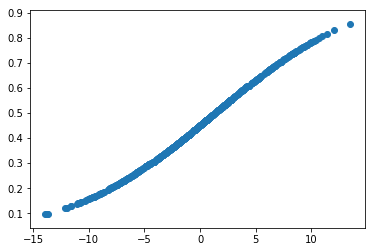

In [31]:
#lets start some modeling
home_differentials['intercept'] = 1 #why do i need to do this?
xData = np.array(home_differentials[['overall_rating', 'intercept']])
yData = (matches['home_win'] == 1)

#Split into test/train sets:
X_train, X_test, y_train, y_test = train_test_split(xData, yData, test_size = .2)

#make the sklearn model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

#evaluate the model's performance
logreg.score(X_train, y_train)
logreg.score(X_test, y_test)
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

#graph the S curve
y_pred_prob = logreg.predict_proba(X_test)[:,1]
X_test = pd.DataFrame(X_test) #I only know how to work with DF's
plt.scatter(X_test[0],y_pred_prob)